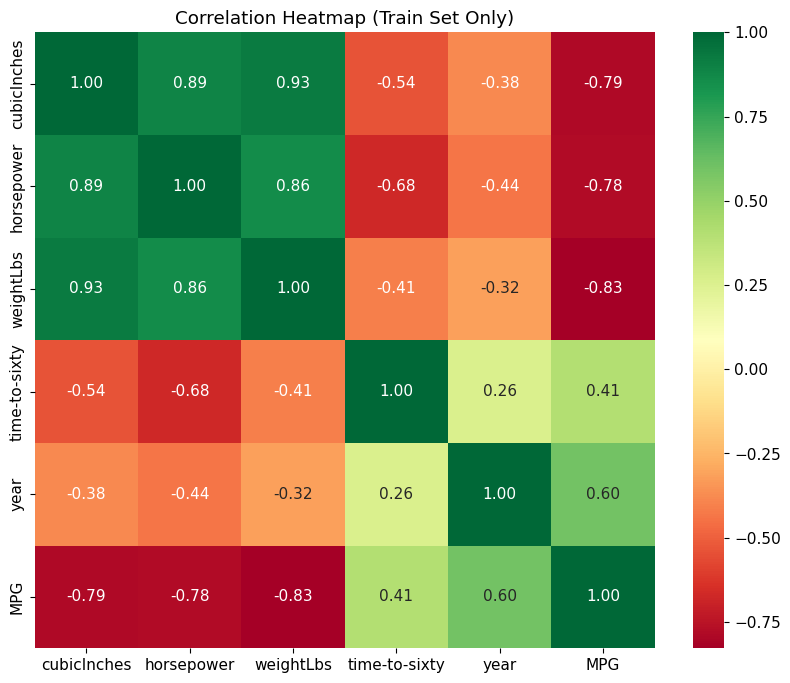

Lasso selected 3 features:
['horsepower', 'weightLbs', 'year']


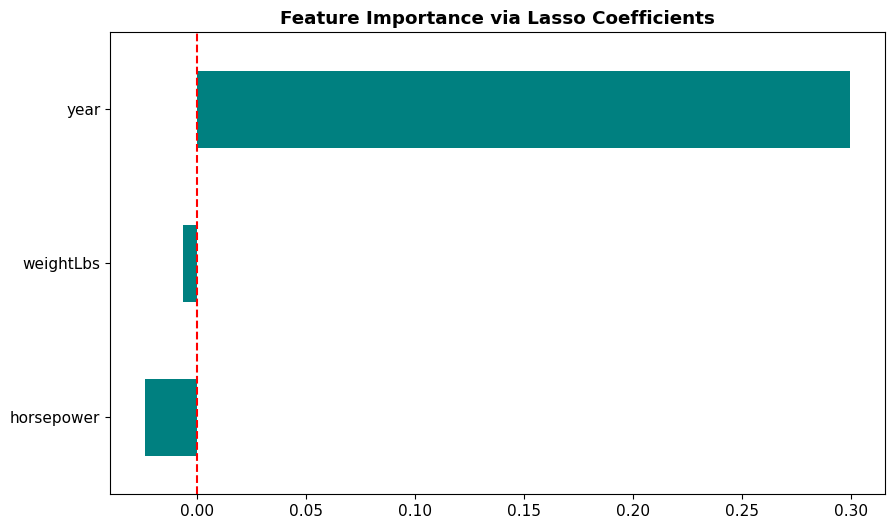

Dataset shape: (392, 8)
Train shape: (274, 3)
Val shape:   (59, 3)
Test shape:  (59, 3)

Basic Statistics:
            MPG  cubicInches  horsepower  weightLbs  time-to-sixty       year
count  392.0000     392.0000    392.0000   392.0000       392.0000   392.0000
mean    23.4459     194.4133    104.4694  2977.5842        15.6811  1976.9796
std      7.8050     104.6428     38.4912   849.4026         2.7612     3.6837
min      9.0000      68.0000     46.0000  1613.0000         8.0000  1971.0000
25%     17.0000     105.0000     75.0000  2225.2500        14.0000  1974.0000
50%     22.7500     151.0000     93.5000  2803.5000        16.0000  1977.0000
75%     29.0000     275.7500    126.0000  3614.7500        17.0000  1980.0000
max     46.6000     455.0000    230.0000  5140.0000        25.0000  1983.0000
Missing values: 0


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import warnings

warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.facecolor': 'white', 'font.size': 11})

#loading car dataset
cars = fetch_openml(name='cars1', version=1, as_frame=True)
df = cars.frame

#feature and target selection
X_all = df.select_dtypes(include=[np.number]).drop(columns=['MPG'], errors='ignore')
y = df['MPG']

#data splitting
X_trainval_all, X_test_all, y_trainval, y_test = train_test_split(
    X_all, y, test_size=0.15, random_state=42
)

X_train_all, X_val_all, y_train, y_val = train_test_split(
    X_trainval_all, y_trainval, test_size=0.15/0.85, random_state=42
)

#correlation analysis
plt.figure(figsize=(10, 8))
train_corr = X_train_all.copy()
train_corr['MPG'] = y_train
sns.heatmap(train_corr.corr(), annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('Correlation Heatmap (Train Set Only)')
plt.show()

#feature selection 
lasso = LassoCV(cv=5, random_state=42).fit(X_train_all, y_train)

model_coeffs = pd.Series(lasso.coef_, index=X_train_all.columns)
selected_features = model_coeffs[model_coeffs != 0].index.tolist()

print(f"Lasso selected {len(selected_features)} features:")
print(selected_features)

#visualizing Lasso coefficients (Feature Importance)
plt.figure(figsize=(10, 6))
model_coeffs[model_coeffs != 0].sort_values().plot(kind='barh', color='teal')
plt.title('Feature Importance via Lasso Coefficients', fontweight='bold')
plt.axvline(x=0, color='red', linestyle='--')
plt.show()

#filtering datasets
X_train = X_train_all[selected_features].values
X_val   = X_val_all[selected_features].values
X_test  = X_test_all[selected_features].values

#feature scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

print(f'Dataset shape: {df.shape}')
print(f'Train shape: {X_train_s.shape}')
print(f'Val shape:   {X_val_s.shape}')
print(f'Test shape:  {X_test_s.shape}')
print('\nBasic Statistics:')
print(df.describe().round(4))
print(f'Missing values: {df.isnull().sum().sum()}')

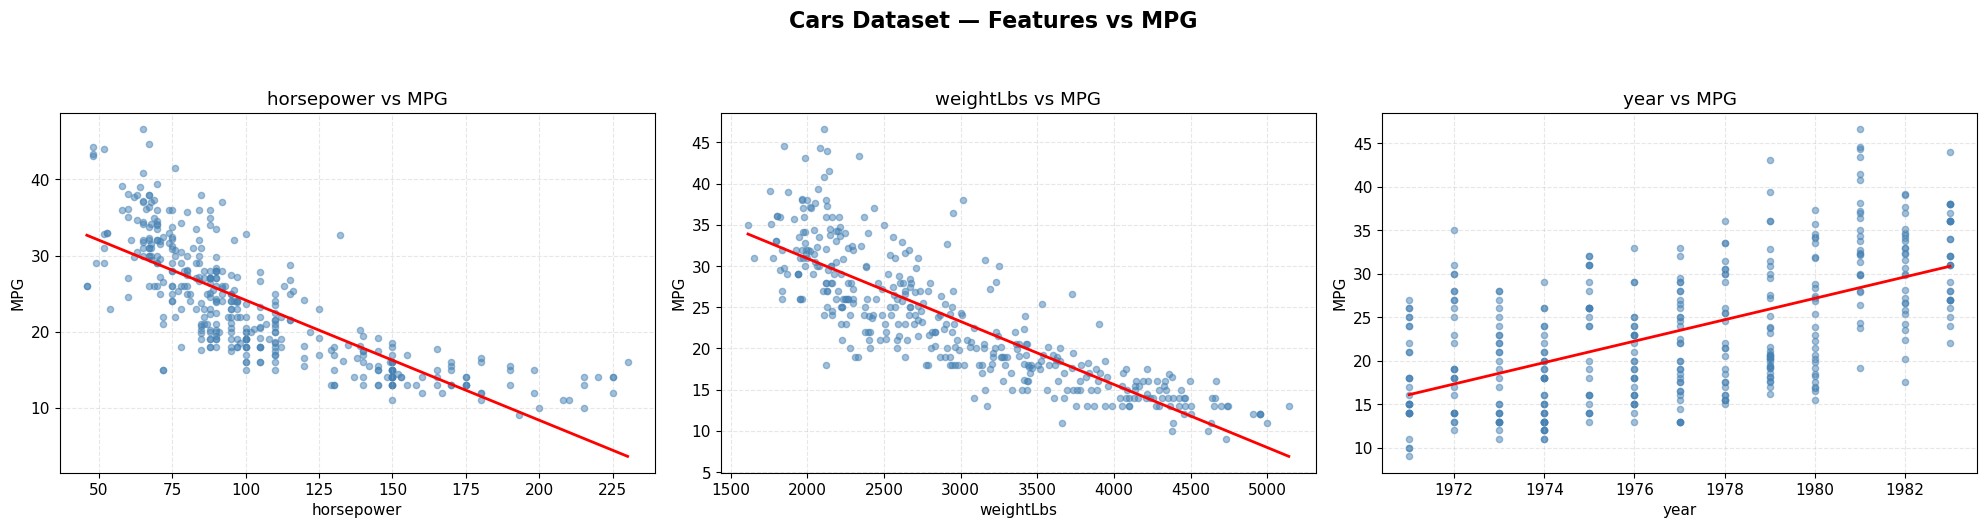

In [14]:
fig, axes = plt.subplots(1, len(selected_features), figsize=(20, 5))

for i, feat in enumerate(selected_features):
    axes[i].scatter(df[feat], df['MPG'], alpha=0.5, s=20, color='steelblue')
    m, b = np.polyfit(df[feat], df['MPG'], 1)
    x_line = np.linspace(df[feat].min(), df[feat].max(), 100)
    axes[i].plot(x_line, m*x_line + b, 'r-', lw=2)
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel('MPG')
    axes[i].set_title(f'{feat} vs MPG')
    axes[i].grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Cars Dataset — Features vs MPG', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

In [15]:
def ols_fit(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    ones = np.ones((X.shape[0], 1))
    X_b = np.hstack([ones, X])
    w_star = np.linalg.pinv(X_b.T @ X_b) @ (X_b.T @ y)
    return w_star

def ols_predict(X: np.ndarray, w: np.ndarray) -> np.ndarray:
    ones = np.ones((X.shape[0], 1))
    X_b = np.hstack([ones, X])
    return X_b @ w

w_ols = ols_fit(X_train_s, y_train)

print('OLS Weights (intercept + feature coefficients):')
print(f'Intercept : {w_ols[0]:.4f}')
for name, coef in zip(selected_features, w_ols[1:]):
    print(f'{name:>10} : {coef:.4f}')

sk_model = LinearRegression()
sk_model.fit(X_train_s, y_train)

print('sklearn Weights:')
print(f'  Intercept : {sk_model.intercept_:.4f}')
for name, coef in zip(selected_features, sk_model.coef_):
    print(f'{name:>9} : {coef:.4f}')

max_diff = np.max(np.abs(w_ols[1:] - sk_model.coef_))
print(f'\nMax coefficient difference (OLS vs sklearn): {max_diff:.2e}')
print('→ OLS and sklearn produce IDENTICAL results ')

OLS Weights (intercept + feature coefficients):
Intercept : 23.6372
horsepower : -0.3067
 weightLbs : -5.4304
      year : 2.9088
sklearn Weights:
  Intercept : 23.6372
horsepower : -0.3067
weightLbs : -5.4304
     year : 2.9088

Max coefficient difference (OLS vs sklearn): 1.55e-14
→ OLS and sklearn produce IDENTICAL results 


In [16]:
def evaluate(y_true, y_pred, label):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)
    print(f'{label:<25}  MSE={mse:>8.2f}  RMSE={rmse:>7.2f}  R²={r2:.4f}')
    return mse, rmse, r2
    
y_val_ols  = ols_predict(X_val_s,  w_ols)
y_val_sk   = sk_model.predict(X_val_s)

y_test_ols = ols_predict(X_test_s, w_ols)
y_test_sk  = sk_model.predict(X_test_s)

print('─'*65)
print(f'{"Method":<25}  {"MSE":>8}  {"RMSE":>7}  {"R²"}')
print('─'*65)

mse_ov,  rmse_ov,  r2_ov  = evaluate(y_val,  y_val_ols,  'OLS — Validation')
mse_sv,  rmse_sv,  r2_sv  = evaluate(y_val,  y_val_sk,   'sklearn — Validation')

print('─'*65)

mse_ot,  rmse_ot,  r2_ot  = evaluate(y_test, y_test_ols, 'OLS — Test')
mse_st,  rmse_st,  r2_st  = evaluate(y_test, y_test_sk,  'sklearn — Test')

print('─'*65)

─────────────────────────────────────────────────────────────────
Method                          MSE     RMSE  R²
─────────────────────────────────────────────────────────────────
OLS — Validation           MSE=   10.28  RMSE=   3.21  R²=0.8088
sklearn — Validation       MSE=   10.28  RMSE=   3.21  R²=0.8088
─────────────────────────────────────────────────────────────────
OLS — Test                 MSE=   10.97  RMSE=   3.31  R²=0.7903
sklearn — Test             MSE=   10.97  RMSE=   3.31  R²=0.7903
─────────────────────────────────────────────────────────────────


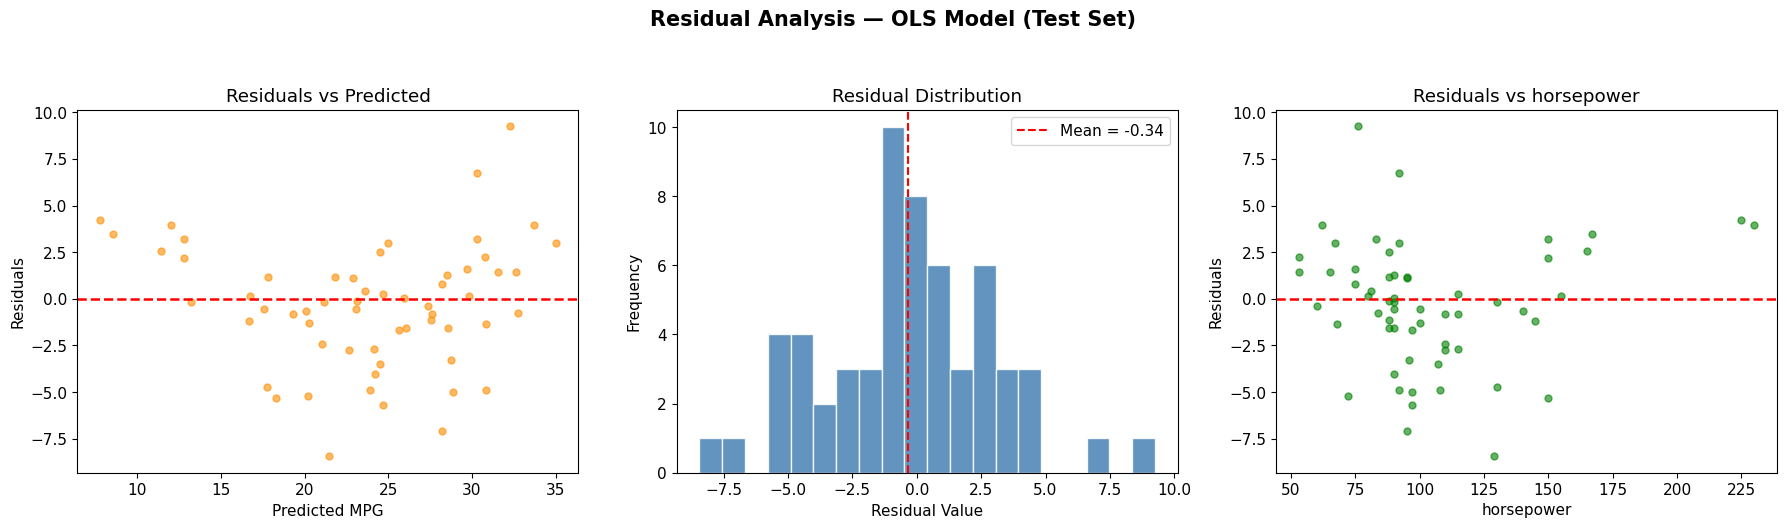

Residual stats — mean: -0.343, std: 3.322
Min: -8.44, Max: 9.25


In [17]:
residuals = y_test - y_test_ols

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(y_test_ols, residuals, alpha=0.6, s=25, color='darkorange')
axes[0].axhline(0, color='red', lw=1.8, ls='--')
axes[0].set_xlabel('Predicted MPG')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Predicted')

axes[1].hist(residuals, bins=20, color='steelblue', edgecolor='white', alpha=0.85)
axes[1].axvline(residuals.mean(), color='red', ls='--', lw=1.5, label=f'Mean = {residuals.mean():.2f}')
axes[1].set_xlabel('Residual Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')
axes[1].legend()

top_feat = selected_features[0] 
axes[2].scatter(X_test[:, 0], residuals, alpha=0.6, s=25, color='green')
axes[2].axhline(0, color='red', lw=1.8, ls='--')
axes[2].set_xlabel(top_feat)
axes[2].set_ylabel('Residuals')
axes[2].set_title(f'Residuals vs {top_feat}')

plt.suptitle('Residual Analysis — OLS Model (Test Set)', fontsize=15, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

print(f'Residual stats — mean: {residuals.mean():.3f}, std: {residuals.std():.3f}')
print(f'Min: {residuals.min():.2f}, Max: {residuals.max():.2f}')

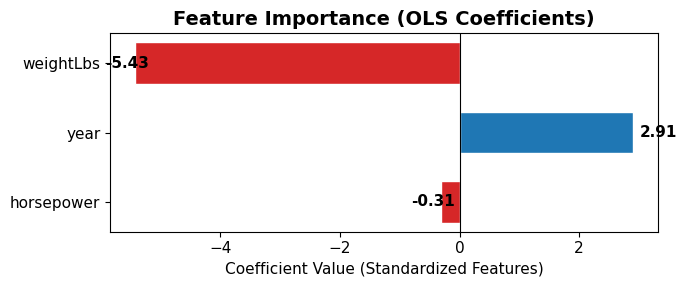

In [18]:
coef_vals  = w_ols[1:]
sorted_idx = np.argsort(np.abs(coef_vals))[::-1]
sorted_feats = [selected_features[i] for i in sorted_idx]
sorted_coefs = coef_vals[sorted_idx]

colors = ['#d62728' if c < 0 else '#1f77b4' for c in sorted_coefs]

fig, ax = plt.subplots(figsize=(7, 3))
bars = ax.barh(sorted_feats, sorted_coefs, color=colors, edgecolor='white', height=0.6)
ax.axvline(0, color='black', lw=0.8)
ax.invert_yaxis() 

ax.set_xlabel('Coefficient Value (Standardized Features)')
ax.set_title('Feature Importance (OLS Coefficients)', fontweight='bold', fontsize=14)

for bar, val in zip(bars, sorted_coefs):
    x_pos = val + (0.1 if val >= 0 else -0.5)
    ax.text(x_pos, bar.get_y() + bar.get_height()/2,
            f'{val:.2f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [19]:
print('COEFFICIENT INTERPRETATION')
print('='*70)
print(f'Intercept: {w_ols[0]:.2f} → Baseline MPG when all features are at their mean')
print()

for name, coef in zip(selected_features, w_ols[1:]):
    direction = 'INCREASES' if coef > 0 else 'DECREASES'
    print(f'{name:>12}: {coef:>8.2f}  → 1 SD increase in {name} {direction} '
          f'fuel efficiency (MPG) by {abs(coef):.2f} units')

COEFFICIENT INTERPRETATION
Intercept: 23.64 → Baseline MPG when all features are at their mean

  horsepower:    -0.31  → 1 SD increase in horsepower DECREASES fuel efficiency (MPG) by 0.31 units
   weightLbs:    -5.43  → 1 SD increase in weightLbs DECREASES fuel efficiency (MPG) by 5.43 units
        year:     2.91  → 1 SD increase in year INCREASES fuel efficiency (MPG) by 2.91 units


In [20]:
joblib.dump({
    'model': sk_model,
    'scaler': scaler,
    'ols_weights': w_ols,
    'feature_names': selected_features 
}, 'linear_regression_model.joblib')

loaded = joblib.load('linear_regression_model.joblib')
test_pred = loaded['model'].predict(X_test_s[:3])

print('--- Verification ---')
print(f'Model saved and verified. \nSample predictions (MPG): {test_pred.round(2)}')
print(f'Features used: {loaded["feature_names"]}')

--- Verification ---
Model saved and verified. 
Sample predictions (MPG): [25.95 28.53 20.07]
Features used: ['horsepower', 'weightLbs', 'year']


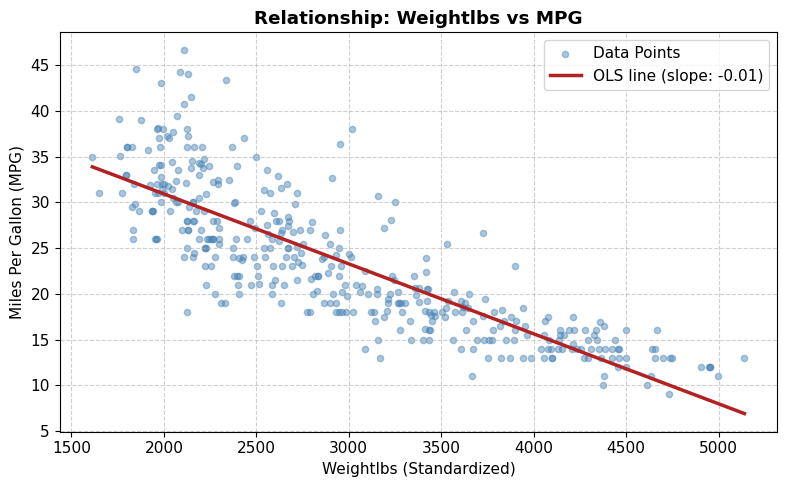

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))

feature_to_plot = 'weightLbs' 
ax.scatter(df[feature_to_plot], df['MPG'], alpha=0.45, s=20, color='steelblue', label='Data Points')

x_line = np.linspace(df[feature_to_plot].min(), df[feature_to_plot].max(), 200)
m, b = np.polyfit(df[feature_to_plot], df['MPG'], 1)
ax.plot(x_line, m*x_line + b, color='firebrick', lw=2.5, label=f'OLS line (slope: {m:.2f})')

ax.set_xlabel(f'{feature_to_plot.capitalize()} (Standardized)')
ax.set_ylabel('Miles Per Gallon (MPG)')
ax.set_title(f'Relationship: {feature_to_plot.capitalize()} vs MPG', fontweight='bold')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

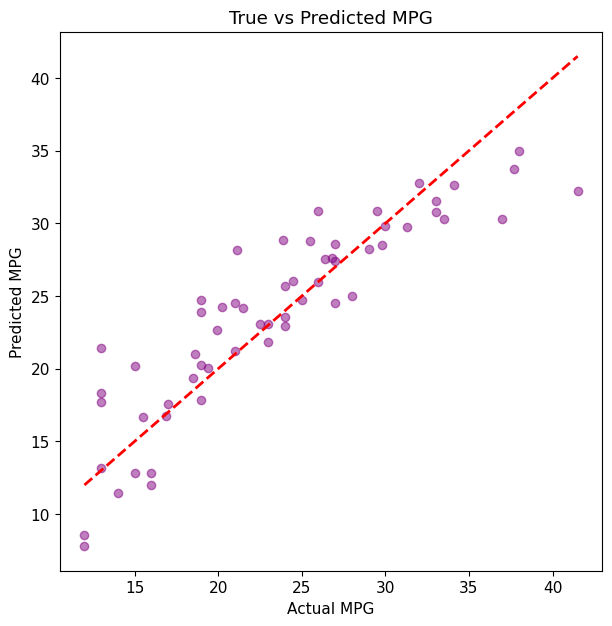

In [23]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_test_ols, color='purple', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual MPG')
plt.ylabel('Predicted MPG')
plt.title('True vs Predicted MPG')
plt.show()